# Mobile app usage



Dataset: **Mobile app usage**  `lsapp.tsv`

Source: https://github.com/aliannejadi/LSApp/tree/main

Original article: Mohammad Aliannejadi, Hamed Zamani, Fabio Crestani, and W. Bruce Croft. 2021. Context-aware Target Apps Selection and Recommendation for Enhancing Personal Mobile Assistants. ACM Trans. Inf. Syst. 39, 3, Article 29 (July 2021), 30 pages. https://doi.org/10.1145/3447678


This starter notebook includes the *original preprocessing* steps in `LSApp`, and a few visualizations to get you started.  You can download the processed file used in this notebook here: [app usage](https://ucdavis.box.com/s/6of233heq70qcp77mt19zcm80y8t0e8x).

## 1 Data preprocessing

In [4]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle
import nltk

In [5]:
#  Adjust the path below if your lsapp.tsv lives elsewhere
df = pd.read_csv('../data/raw/lsapp.tsv', sep='\t')
df_open = df.loc[df['event_type'] == 'Opened']

In [6]:
df_open.loc[:, 'timestamp'] = pd.to_datetime(df_open['timestamp'])
df.loc[:, 'timestamp'] = pd.to_datetime(df['timestamp'])


In [7]:
df['time_dff'] = df[['timestamp']].diff()

df['interaction_id'] = (
    ((df.timestamp - df.timestamp.shift(1) > pd.Timedelta(1, 'm')) & (df.event_type == 'Opened'))
    | ~(df.app_name == df.app_name.shift(1))
    | ~(df.user_id == df.user_id.shift(1))
).cumsum()

df['session_id'] = (
    ((df.timestamp - df.timestamp.shift(1) > pd.Timedelta(5, 'm')) & (df.event_type == 'Opened'))
    | ~(df.user_id == df.user_id.shift(1))
).cumsum()
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [8]:
# Quick preview of the interaction‑level table
df.head()

,user_id,session_id,timestamp,app_name,event_type,time_dff,interaction_id
0,0,1,2018-01-16 06:01:05,Minesweeper Classic (Mines),Opened,NaN,1
1,0,1,2018-01-16 06:01:05,Minesweeper Classic (Mines),Closed,0 days 00:00:00,1
2,0,1,2018-01-16 06:01:07,Minesweeper Classic (Mines),Opened,0 days 00:00:02,1
3,0,1,2018-01-16 06:01:07,Minesweeper Classic (Mines),Closed,0 days 00:00:00,1
4,0,1,2018-01-16 06:01:08,Minesweeper Classic (Mines),Opened,0 days 00:00:01,1


In [9]:
df_start = df.drop_duplicates(subset=['interaction_id'], keep='first')
df_end   = df.drop_duplicates(subset=['interaction_id'], keep='last')
df_start.set_index('interaction_id', inplace=True)
df_end.set_index('interaction_id', inplace=True)
df_start.loc[:, 'open_time']  = df_start['timestamp']
df_start.loc[:, 'close_time'] = df_end['timestamp']

/var/folders/70/nplvvvvs69dcsdrp16h2_0l80000gn/T/ipykernel_10035/3382392550.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_start.loc[:, 'open_time']  = df_start['timestamp']
/var/folders/70/nplvvvvs69dcsdrp16h2_0l80000gn/T/ipykernel_10035/3382392550.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_start.loc[:, 'close_time'] = df_end['timestamp']


In [10]:
df_start.head()

,user_id,session_id,timestamp,app_name,event_type,time_dff,open_time,close_time
interaction_id,,,,,,,,
1,0,1,2018-01-16 06:01:05,Minesweeper Classic (Mines),Opened,NaN,2018-01-16 06:01:05,2018-01-16 06:01:09
2,0,1,2018-01-16 06:03:44,Minesweeper Classic (Mines),Opened,0 days 00:02:35,2018-01-16 06:03:44,2018-01-16 06:04:17
3,0,1,2018-01-16 06:25:54,Gmail,User Interaction,0 days 00:21:37,2018-01-16 06:25:54,2018-01-16 06:25:54
4,0,1,2018-01-16 06:26:05,Google,Opened,0 days 00:00:11,2018-01-16 06:26:05,2018-01-16 06:26:10
5,0,1,2018-01-16 06:26:10,Instagram,Opened,0 days 00:00:00,2018-01-16 06:26:10,2018-01-16 06:26:21


>**Tip** Take a small subset to explore if necessary.

## 2 Exploratory data analysis

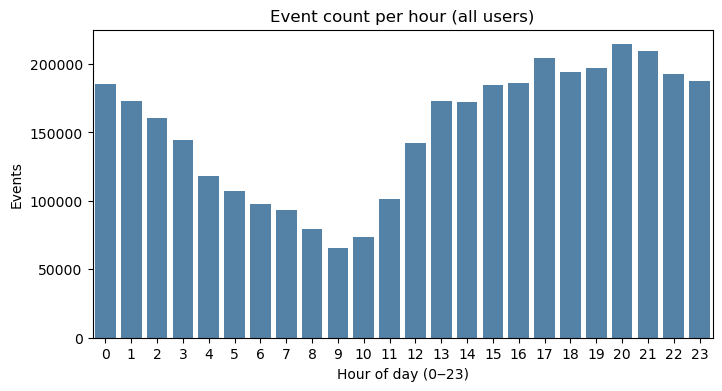

In [11]:
# ───────────────────────────────────────────────────────────────
# Idea 1. Daily rhythm – event volume by hour of day
# ───────────────────────────────────────────────────────────────
df['hour'] = df['timestamp'].dt.hour
plt.figure(figsize=(8,4))
sns.countplot(x='hour', data=df, color='steelblue')
plt.title('Event count per hour (all users)')
plt.xlabel('Hour of day (0‒23)')
plt.ylabel('Events')
plt.show()


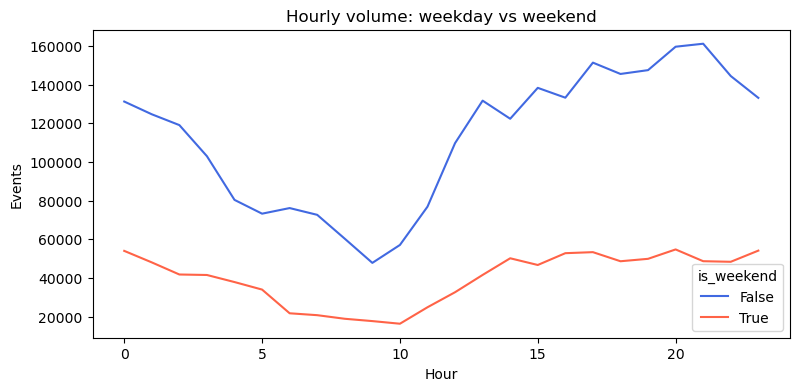

In [12]:
# ───────────────────────────────────────────────────────────────
# Idea 2. Weekend vs weekday hourly pattern
# ───────────────────────────────────────────────────────────────

df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5      # 0=Mon … 6=Sun
pivot = (df
         .groupby([df['timestamp'].dt.hour, 'is_weekend'])
         .size()
         .reset_index(name='n'))
plt.figure(figsize=(9,4))
sns.lineplot(data=pivot,
             x='timestamp', y='n', hue='is_weekend',
             palette=['royalblue','tomato'])
plt.title('Hourly volume: weekday vs weekend')
plt.xlabel('Hour')
plt.ylabel('Events')
plt.show()


/var/folders/70/nplvvvvs69dcsdrp16h2_0l80000gn/T/ipykernel_10035/238603936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_start['minutes'] = (df_start['close_time']-df_start['open_time']).dt.total_seconds()/60


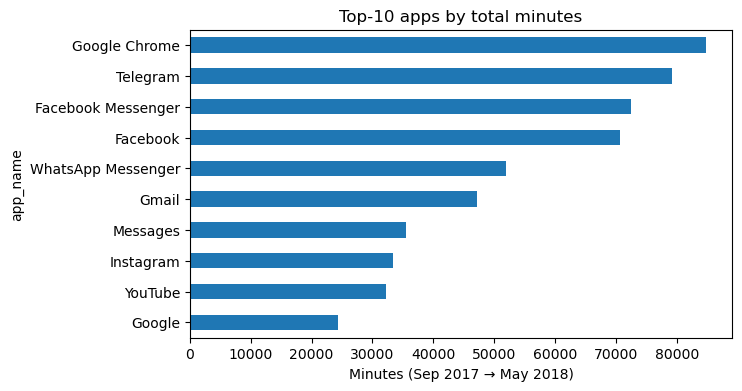

In [13]:
# ───────────────────────────────────────────────────────────────
# Idea 3. Top-10 apps by cumulative screen-time
# ───────────────────────────────────────────────────────────────
df_start['minutes'] = (df_start['close_time']-df_start['open_time']).dt.total_seconds()/60
top10_screen = (df_start.groupby('app_name')['minutes']
                         .sum()
                         .sort_values(ascending=False)
                         .head(10))
plt.figure(figsize=(7,4))
top10_screen.plot(kind='barh')
plt.title('Top-10 apps by total minutes')
plt.xlabel('Minutes (Sep 2017 → May 2018)')
plt.gca().invert_yaxis()
plt.show()


In [17]:
df.head()
df['app_name'].value_counts()

app_name
Facebook              506209
Google Chrome         321183
Facebook Messenger    237622
Google                210108
Twitter               186339
                       ...  
TextNow                  944
Pixlr                    209
Text One                  48
Flickr                    24
Brave Browser             22
Name: count, Length: 87, dtype: int64

## 3 Next step?